# Datathon V - Día 3 - MLOps

A continuación se detallan las actividades y puntos asignados para el reto de MLOps del Datathon V. Cada actividad tiene un puntaje específico y una evaluación que indica si se ha completado correctamente.

| **Actividad**                                                             | **Puntos**      | **Evaluación** |
| ------------------------------------------------------------------------- | --------------- | -------------- |
| **Tareas de Pipeline y MLFlow**                                           | **Total: 7**    |                |
| Crear un Pipeline de Scikit-Learn                                         | 0.5             | ✅            |
| Lanzar un servidor MLflow local                                           | 0.5             | ✅            |
| Entrenar y evaluar el modelo dentro de una ejecución de MLflow            | 0.5             | ✅            |
| Registrar el modelo y las métricas con MLflow                             | 0.5             | ✅            |
| Registrar el modelo en MLflow                                             | 0.5             | ✅            |
| Desplegar el modelo como una API REST (con Docker)                        | 2.0             | ✅            |
| Hacer predicciones usando la API REST                                     | 2.0             | ✅            |
| Subir las predicciones a la base de datos                                 | 0.5             | ✅            |
| **Código y Documentación**                                                | **Total: 1**    |               |
| Legibilidad del código                                                    | 0.5             | ✅            |
| Documentación en el notebook (títulos, subtítulos, texto)                 | 0.5             | ✅            |
| **Repositorio GIT**                                                       | **Total: 1**    |                |
| Incluir un archivo README.md completo                                     | 0.5             | ✅            |
| Uso de ramas para el desarrollo                                           | 0.5             | ✅            |
| **Puntos Extra (Bonus)**                                                  | **1 + Bonus**   |                |
| Explorar nuevas técnicas, modelos o productos                             | *Bonus*         | ✅              |
| Crear un pequeño artículo y promocionarlo                                 | *Bonus*         | ✅              |
| Cualquier otra iniciativa personal que mejore el proyecto                 | *Bonus*         | ✅              |
| **Evaluaciones Negativas**                                                | **Total: -9.0** |                  |
| Subir datos al repositorio                                                | -3.0            | ❌              |
| Subir contraseñas o información sensible                                  | -3.0            | ❌              |
| Subir archivos generados por MLflow (ej. `mlruns`)                        | -1.0            | ❌              |
| Faltan archivos estándar de Python (ej. `requirements.txt`, `.gitignore`) | -1.0            | ❌              |
| Un archivo README.md con mala presentación                                | -1.0            | ❌              |


**Notes**:
- Puntos Totales: 10 (sin contar los bonus ni los aspectos negativos).
- Los puntos extra pueden mejorar la puntuación, pero no permiten superar el máximo de 10 puntos.
- Las malas prácticas restan puntos.

## 1. Introducción

Lo primero: ¡Enhorabuena! 🎉 Si has llegado hasta aquí, quiere decir que te estas tomando tu formacion muy en serio. 

En este reto de MLOps, vamos a poner en práctica todo lo aprendido hasta ahora. El objetivo es desplegar un modelo registrado en MLFlow y hacer predicciones con él. Finalmente, subiremos los resultados a una base de datos para que puedan ser consultados durante la ultima fase del Datathon. Repasaremos el preprocesamiento de los datos y el entrenamiento del modelo dandole una vuelta: aprenderemos también a simplificar el procesamiento de los datos haciendo uso de un Pipeline de Scikit-Learn.

¿Listo/a? ¡Vamos a ello! 🚀

## 2. Obtención de los datos

En esta sección, vamos a cargar los datos desde la base de datos y vamos a convertir la serie temporal de ventas en un ejercicio Supervisado.

### 2.1 Cargar los datos desde la base de datos

Nos conectamos a la base de datos y ejecutamos una query para obtener los datos de ventas. Utilizamos la librería `pandas` para manejar los datos y `sqlalchemy` para conectarnos a la base de datos.

In [2]:
# Como en los anteriores notebooks, voy a importar varias dependencias
import polars as pl
import pandas as pd
import numpy as np

import os
from dotenv import load_dotenv  # He hecho archivo .env al inicio del proyecto

import plotly.express as px
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

import sqlalchemy as sa
import sys

In [3]:
class DatabaseConnection:

    # Información necesaria para establecer la conexión a la BBDD
    def __init__(self):
        load_dotenv()  # Variables de entorno
        port = 3306  # Puerto por defecto de MySQL
        user = os.getenv("DB_USER")
        password = os.getenv("DB_PASSWORD")
        host = os.getenv("DB_HOST")
        db_name = os.getenv("DB_NAME") 
        self.engine = create_engine(
            f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db_name}"
        )
    def check_connection(self) -> bool:
        """Check if DB connection works"""
        try:
            with self.engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            print("Conexión establecida correctamente.")
            return True
        except Exception as e:
            print(f"Error de conexión: {e}")
            return False
    def query_to_pandas(self, sql_query: str) -> pd.DataFrame:
        """Execute a query and get a Pandas"""
        try:
            with self.engine.connect() as conn:
                df = pd.read_sql_query(sql_query, conn)
            print("Consulta ejecutada correctamente (Pandas).")
            return df
        except SQLAlchemyError as e:
            print(f"Error SQLAlchemy: {e}")
            return None
        except Exception as e:
            print(f"Error inesperado: {e}")
            return None
    # En el notebook anterior hago esta función pero de query a Polars, en vista de los problemas que me ha dado, aqui ya usaré Pandas
    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserta un DataFrame de Pandas en la base de datos."""
        try:
            df.to_sql(table_name, self.engine, if_exists="replace", index=False)
            print(f"Tabla '{table_name}' insertada correctamente.")
        except Exception as e:
            print(f"Error insertando DataFrame: {e}")
    

Seteamos las Variables de Configuracion

In [4]:
# Seteadas en archivo .env

Conectamos con la base de datos

In [5]:
database = DatabaseConnection()
database.check_connection()

Conexión establecida correctamente.


True

Realizamos la consulta SQL para obtener los datos de ventas

In [6]:
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM ventas_diarias_estudio_completo
"""

# Obtenemos el DataFrame de la base de datos
df = database.query_to_pandas(query)

df.info()

Consulta ejecutada correctamente (Pandas).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10574 non-null  object 
 1   articulo                10574 non-null  object 
 2   fecha_venta             10574 non-null  object 
 3   festivo                 837 non-null    object 
 4   precio                  10574 non-null  float64
 5   cantidad                10574 non-null  float64
 6   importe                 10574 non-null  float64
 7   orden_articulo_familia  10574 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 661.0+ KB


In [7]:
# Pequeña comprobación para ver si devuelve resultados
if df is not None and not df.empty:
    print("Datos cargados correctamente:")
    display(df.head())
else:
    print("No se cargaron datos.")

Datos cargados correctamente:


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3880,2021-05-01,None,2.591,3705.000000,9599.654968,3
1,BOLLERIA,3960,2021-05-01,None,2.318,5226.000000,12113.867931,1
2,BOLLERIA,5803,2021-05-01,None,2.727,3081.000000,8401.886749,5
3,BOLLERIA,6286,2021-05-01,None,3.136,2145.000000,6726.720081,4
4,BOLLERIA,6425,2021-05-01,None,31.364,412.424994,12935.287083,2


#### La mayoría de operaciones que hay que hacer ahora, las tengo hechas en el notebook03 de EDA (de Alba y Juan), aunque he usado Polars, así que voy a volver a realizar los siguientes pasos pero con Pandas

In [8]:
print(df.describe())

             precio      cantidad       importe  orden_articulo_familia
count  10574.000000  10574.000000  10574.000000            10574.000000
mean      15.414053   1789.943391   6012.770320                2.961982
std       17.003998   1926.139421   3564.015384                1.395454
min        0.865000     15.600001    117.000000                1.000000
25%        2.591000    195.000000   3742.537502                2.000000
50%        3.545000   1092.000000   5265.000000                3.000000
75%       34.091000   2847.000000   7405.515973                4.000000
max       43.500000  14430.000000  42535.089508                5.000000


In [9]:
# Compruebo las columnas que hay y sus tipos
print(df.columns)
print(df.dtypes)

Index(['familia', 'articulo', 'fecha_venta', 'festivo', 'precio', 'cantidad',
       'importe', 'orden_articulo_familia'],
      dtype='object')
familia                    object
articulo                   object
fecha_venta                object
festivo                    object
precio                    float64
cantidad                  float64
importe                   float64
orden_articulo_familia      int64
dtype: object


Convertimos las fechas a formato datetime y los artículos a tipo int

In [10]:
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)

In [11]:
# Comprobación de tipos
print(df.dtypes)

familia                           object
articulo                           int64
fecha_venta               datetime64[ns]
festivo                           object
precio                           float64
cantidad                         float64
importe                          float64
orden_articulo_familia             int64
dtype: object


### 2.2 Filtramos para un solo producto

Hemos seleccionado el PRODUCT_ID 3960, pero podemos seleccionar cualquier otro producto.

In [12]:
# Voy a seleccionar el producto más vendido
top_sales_product = df.groupby("articulo")["cantidad"].sum().sort_values(ascending=False)
print(top_sales_product.head(1))

articulo
900    4272333.0
Name: cantidad, dtype: float64


In [13]:
# Hemos visto que el artículo 900 es el más vendido
PRODUCT_ID = 900

# Filtramos el DataFrame para el producto deseado
item_df = df.loc[df["articulo"] == PRODUCT_ID].copy()
print(item_df)

        familia  articulo fecha_venta          festivo  precio  cantidad  \
3737  PANADERIA       900  2021-05-01             None   0.865    8463.0   
3742  PANADERIA       900  2021-05-02  Día de la Madre   0.865   11232.0   
3747  PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7215.0   
3752  PANADERIA       900  2021-05-04             None   0.865    6045.0   
3757  PANADERIA       900  2021-05-05             None   0.865    5616.0   
...         ...       ...         ...              ...     ...       ...   
7452  PANADERIA       900  2023-05-14             None   1.050    2730.0   
7457  PANADERIA       900  2023-05-15             None   1.050    2184.0   
7462  PANADERIA       900  2023-05-16             None   1.050    1209.0   
7467  PANADERIA       900  2023-05-17             None   1.050    1599.0   
7472  PANADERIA       900  2023-05-18             None   1.050    1911.0   

          importe  orden_articulo_familia  
3737  7320.494969                       3  

Organizamos los datos por fecha y reiniciamos el índice

In [14]:
# Ordenamos por fecha de venta y reseteo del índice
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
display(item_df.head())

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,PANADERIA,900,2021-05-01,None,0.865,8463.0,7320.494969,3
1,PANADERIA,900,2021-05-02,Día de la Madre,0.865,11232.0,9715.680036,3
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7215.0,6240.975019,3
3,PANADERIA,900,2021-05-04,None,0.865,6045.0,5228.925082,3
4,PANADERIA,900,2021-05-05,None,0.865,5616.0,4857.839948,3


### 2.3 Convertimos la serie a formato supervisado

Para poder predecir las ventas, necesitamos transformar los datos en un problema supervisado. Para ello vamos a:

- 👉 Obtener la `cantidad` contabilizada los días anteriores y añadirlos al día presente (shift).
- 👉 Obtener la `cantidad` contabilizada las semanas anteriores y añadirlos al día presente (shift).

👇 Para facilitar el proceso hemos diseñado una función que nos permite transformar la serie a formato supervisado. Esta función recibe como parámetros el dataframe, el número de días y semanas a considerar.

In [15]:
# Prácticamente he usado la misma función, algun "retoque" pero es la misma
def series_to_supervised(
    df: pd.DataFrame,
    target_column: str = "cantidad",
    daily_lag: int = 1,
    weekly_lag: int = 1,
    weekly_period: int = 7,  # Permite cambiar el periodo semanal si fuera necesario
) -> pd.DataFrame:
    """
    Converts a time series dataset into a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a numpy array or DataFrame.
        daily_lag: Number of daily lag observations to include as inputs (X).
        weekly_lag: Number of weekly lag observations to include as inputs (X).
    
    Returns:
        Pandas DataFrame suitable for supervised learning.
    """
    final_df = df.copy()
    target_feature = final_df[target_column]

    # Función interna para crear los lags
    def create_shifted_feature(lag: int, frequency: int, freq_label: str):
        shifted_feature = target_feature.shift(lag * frequency)
        feature_name = f"{target_feature.name} (t-{lag} {freq_label})"
        final_df[feature_name] = shifted_feature

    # Add weekly lagged features
    for lag in range(weekly_lag, 0, -1):
        create_shifted_feature(lag, 7, "weeks")

    # Add daily lagged features
    for lag in range(daily_lag, 0, -1):
        create_shifted_feature(lag, 1, "days")

    return final_df

In [16]:
# Usamos la función con el artículo o ítem seleccionado

item_df_supervised = series_to_supervised(item_df, target_column="cantidad", daily_lag=6, weekly_lag=4)
display(item_df_supervised.head(10))

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,PANADERIA,900,2021-05-01,None,0.865,8463.0,7320.494969,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PANADERIA,900,2021-05-02,Día de la Madre,0.865,11232.0,9715.680036,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8463.0
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7215.0,6240.975019,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8463.0,11232.0
3,PANADERIA,900,2021-05-04,None,0.865,6045.0,5228.925082,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8463.0,11232.0,7215.0
4,PANADERIA,900,2021-05-05,None,0.865,5616.0,4857.839948,3,NaN,NaN,NaN,NaN,NaN,NaN,8463.0,11232.0,7215.0,6045.0
5,PANADERIA,900,2021-05-06,None,0.865,6318.0,5465.070060,3,NaN,NaN,NaN,NaN,NaN,8463.0,11232.0,7215.0,6045.0,5616.0
6,PANADERIA,900,2021-05-07,None,0.865,7488.0,6477.119938,3,NaN,NaN,NaN,NaN,8463.0,11232.0,7215.0,6045.0,5616.0,6318.0
7,PANADERIA,900,2021-05-08,None,0.865,11076.0,9580.740068,3,NaN,NaN,NaN,8463.0,11232.0,7215.0,6045.0,5616.0,6318.0,7488.0
8,PANADERIA,900,2021-05-09,None,0.865,9126.0,7893.990013,3,NaN,NaN,NaN,11232.0,7215.0,6045.0,5616.0,6318.0,7488.0,11076.0
9,PANADERIA,900,2021-05-10,None,0.865,5148.0,4453.020034,3,NaN,NaN,NaN,7215.0,6045.0,5616.0,6318.0,7488.0,11076.0,9126.0


## 3. Preprocesamiento de los datos

Hasta ahora en clase hemos visto como podemos modificar los datos de entrada para adaptarlos a los modelos. En este caso vamos a ir un paso más allá y vamos a **crear un Flujo de Transformacion de Datos (Data Pipeline)** que nos permita transformar los datos de entrada en un formato adecuado para el modelo.

Cuales son las transformaciones que vamos a realizar?

- 👉 **Extraer info de la fecha de venta**: el día, el mes, el año, el día de la semana y si es fin de semana o no.
- 👉 **Indicar si el día es festivo o no.**
- 👉 **Agregar informacion meteorológica**: temperatura, humedad, velocidad del viento y precipitaciones...


💡El uso de funciones nos permite reutilizar el codigo tantas veces como queramos.

### 3.1 Extraemos info de la fecha de venta

A traves de la fecha de venta vamos a crear las siguientes columnas:

- 👉 El día de la semana ( `dayofweek`)
- 👉 El día del mes (`day`)
- 👉 El mes (`month`)
- 👉 El año (`year`)
- 👉 Si es fin de semana o no (`weekend`)

In [ ]:
# Añadimos columnas relacionadas con fechas
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df = df.copy()    # Así evito modificar el original fuera de la función
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1  # Lunes=1...Domingo=7
    df["isWeekend"] = (df["dayofweek"] >= 6).astype(int)  # Entero preparado para ml
    return df

item_df_tmp = item_df.copy()
item_df_tmp = add_date_columns(item_df_tmp)
display(item_df_tmp.head())

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,day,month,year,dayofweek,isWeekend
0,PANADERIA,900,2021-05-01,None,0.865,8463.0,7320.494969,3,1,5,2021,6,1
1,PANADERIA,900,2021-05-02,Día de la Madre,0.865,11232.0,9715.680036,3,2,5,2021,7,1
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7215.0,6240.975019,3,3,5,2021,1,0
3,PANADERIA,900,2021-05-04,None,0.865,6045.0,5228.925082,3,4,5,2021,2,0
4,PANADERIA,900,2021-05-05,None,0.865,5616.0,4857.839948,3,5,5,2021,3,0


### 3.2 Indicamos si es festivo o no

Para ello sustituimos los valores de la columna `isHoliday` por `True` si el día es festivo y `False` si no lo es. A continuación, eliminamos la columna `festivo`, de tipo `str`, ya que no la vamos a necesitar.

In [22]:
# Añadimos la columna de si es festivo o no
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    df = df.copy()  # Sin modificar el original
    df["isHoliday"]  = ~df[holiday_column_name].isna()
    df["isHoliday"] = df["isHoliday"].astype(int)  # Entero (0/1)
    df.drop(columns=[holiday_column_name], inplace=True)
    return df

item_df_tmp = item_df.copy()
item_df_tmp = add_holiday_column(item_df_tmp)
display(item_df_tmp.head())

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,isHoliday
0,PANADERIA,900,2021-05-01,0.865,8463.0,7320.494969,3,0
1,PANADERIA,900,2021-05-02,0.865,11232.0,9715.680036,3,1
2,PANADERIA,900,2021-05-03,0.865,7215.0,6240.975019,3,1
3,PANADERIA,900,2021-05-04,0.865,6045.0,5228.925082,3,0
4,PANADERIA,900,2021-05-05,0.865,5616.0,4857.839948,3,0


### 3.3 Agregamos la información meteorológica

Utilizamos la API de meteostat para obtener los datos meteorológicos.

- 👉 Añadir las condiciones meteorológicas para las fechas en el dataframe
- 👉 Añadir una columna `rain` que indique si ese dia hubo o no lluvia (verdadero/falso).

In [28]:
# Establezco el código correcto para LOCATION con variables de entorno
def get_location_from_env(varname="LOCATION"):
    loc = os.getenv(varname)
    loc = loc.replace("(", "").replace(")", "").replace(" ", "")
    lat, lon = map(float, loc.split(","))
    return (lat, lon)

location = get_location_from_env()


In [ ]:
# Añadimos información meteorológica con la API
from datetime import datetime
from meteostat import Point, Daily
import numpy as np


def get_weather_df(start: datetime, end: datetime, location: tuple[float, float]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="left").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    df = df.copy()
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

def add_weather_columns(
    df: pd.DataFrame,
    location: tuple[float, float],   # He cambiado de int a float por si las coordenadas tuvieran decimales
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_df(start, end, location)
    weather_df = add_rain_column(weather_df)
    weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
    return weather_df

In [31]:
# Vemos el weather df

item_df_tmp = add_weather_columns(item_df_tmp, location)
display(item_df_tmp.head())

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,isHoliday,time_x,tavg_x,...,tmin_y,tmax_y,prcp_y,snow_y,wdir_y,wspd_y,wpgt_y,pres_y,tsun_y,isRaining_y
0,PANADERIA,900,2021-05-01,0.865,8463.0,7320.494969,3,0,2021-05-01,17.2,...,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PANADERIA,900,2021-05-02,0.865,11232.0,9715.680036,3,1,2021-05-02,16.3,...,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PANADERIA,900,2021-05-03,0.865,7215.0,6240.975019,3,1,2021-05-03,15.3,...,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PANADERIA,900,2021-05-04,0.865,6045.0,5228.925082,3,0,2021-05-04,16.5,...,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PANADERIA,900,2021-05-05,0.865,5616.0,4857.839948,3,0,2021-05-05,16.7,...,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False


In [32]:
item_df_tmp

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,isHoliday,time_x,tavg_x,...,tmin_y,tmax_y,prcp_y,snow_y,wdir_y,wspd_y,wpgt_y,pres_y,tsun_y,isRaining_y
0,PANADERIA,900,2021-05-01,0.865,8463.0,7320.494969,3,0,2021-05-01,17.2,...,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PANADERIA,900,2021-05-02,0.865,11232.0,9715.680036,3,1,2021-05-02,16.3,...,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PANADERIA,900,2021-05-03,0.865,7215.0,6240.975019,3,1,2021-05-03,15.3,...,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PANADERIA,900,2021-05-04,0.865,6045.0,5228.925082,3,0,2021-05-04,16.5,...,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PANADERIA,900,2021-05-05,0.865,5616.0,4857.839948,3,0,2021-05-05,16.7,...,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,PANADERIA,900,2023-05-14,1.050,2730.0,2866.500043,3,0,2023-05-14,19.4,...,14.1,25.5,0.0,0.0,0.0,12.6,31.5,1018.2,0.0,False
744,PANADERIA,900,2023-05-15,1.050,2184.0,2293.199964,3,0,2023-05-15,23.8,...,15.9,32.0,0.0,0.0,0.0,15.5,33.3,1015.5,0.0,False
745,PANADERIA,900,2023-05-16,1.050,1209.0,1269.450020,3,0,2023-05-16,22.3,...,17.8,26.2,0.0,0.0,0.0,17.6,31.5,1013.0,0.0,False
746,PANADERIA,900,2023-05-17,1.050,1599.0,1678.950014,3,0,2023-05-17,19.2,...,17.2,23.0,0.0,0.0,0.0,9.5,27.8,1013.4,0.0,False


## 4. Creación del Pipeline 

Sklearn nos permite crear un Pipeline de Transformación de Datos que nos permite aplicar las transformaciones de manera secuencial. Al final del pipeline incluiríamos el modelo de Machine Learning que queremos utilizar. De esta manera, podemos aplicar las transformaciones de manera automática cada vez que entrenamos el modelo. Aumentamos la reusabilidad del código y la legibilidad del mismo. Los pasos del pipeline son:

1. Aplicar las transformaciones de los datos de entrada.
2. Normalizar los datos de entrada utilizando OneHotEncoder y MinMaxScaler.
3. Rellenar los valores nulos calculando la media de cada columna.
4. Incluir un modelo de Machine Learning al final del pipeline.
5. Normalizar la variable objetivo (target) utilizando MinMaxScaler.

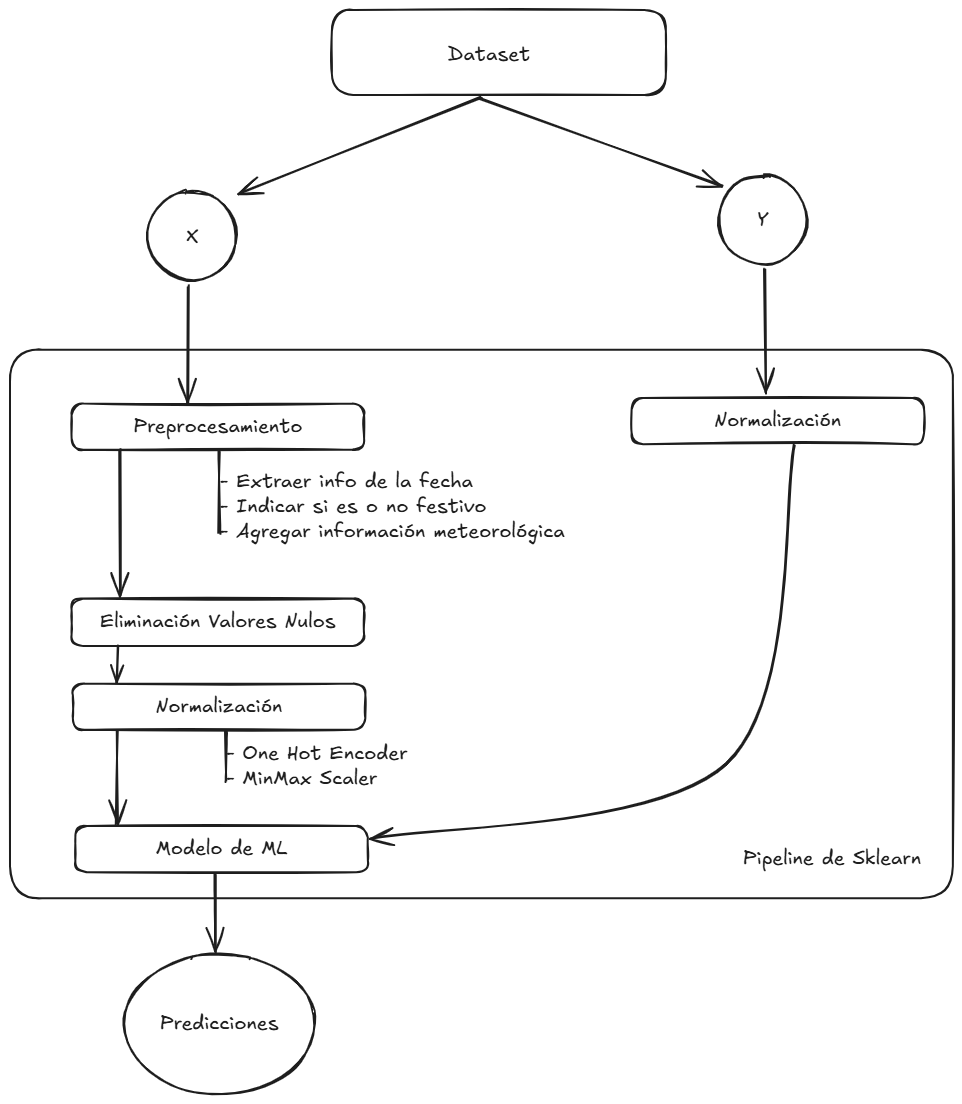

### 4.1 Paso 1: Preprocesamiento de los datos de entrada

Agregamos todas las transformaciones que hemos desarrollado en la sección anterior en un Pipeline de Transformación de Datos.

In [34]:
# Pipeline de transformación de datos
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[float, float]):
        self.location = location

    def fit(self, X: pd.DataFrame, y=None):
        # No necesita que aprenda nada, solamente devuelve self
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X = add_date_columns(X)
        X = add_holiday_column(X)
        X = add_weather_columns(X, location=self.location)
        return X
       

In [41]:
# Probamos la función
preprocessor = PreprocessTransformer(location=location)
df_preprocessed = preprocessor.fit_transform(item_df_supervised)
display(df_preprocessed.head())

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,PANADERIA,900,2021-05-01,0.865,8463.0,7320.494969,3,NaN,NaN,NaN,...,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PANADERIA,900,2021-05-02,0.865,11232.0,9715.680036,3,NaN,NaN,NaN,...,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PANADERIA,900,2021-05-03,0.865,7215.0,6240.975019,3,NaN,NaN,NaN,...,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PANADERIA,900,2021-05-04,0.865,6045.0,5228.925082,3,NaN,NaN,NaN,...,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PANADERIA,900,2021-05-05,0.865,5616.0,4857.839948,3,NaN,NaN,NaN,...,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False


In [ ]:
# Check columnas
df_preprocessed.columns

Index(['familia', 'articulo', 'fecha_venta', 'precio', 'cantidad', 'importe',
       'orden_articulo_familia', 'cantidad (t-4 weeks)',
       'cantidad (t-3 weeks)', 'cantidad (t-2 weeks)', 'cantidad (t-1 weeks)',
       'cantidad (t-6 days)', 'cantidad (t-5 days)', 'cantidad (t-4 days)',
       'cantidad (t-3 days)', 'cantidad (t-2 days)', 'cantidad (t-1 days)',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday', 'time',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'isRaining'],
      dtype='object')

### 4.2 Paso 2: Eliminar los valores nulos

En este paso simplemente rellenamos los valores nulos calculando la media de cada columna.

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

# Solo columnas numéricas
numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

# Imputador de la media
nans_remover = SimpleImputer(strategy="mean")

# ColumnTransformer para aplicar el imputador solo a las numéricas
remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
    remainder="passthrough"   # Deja el resto de columnas como estan
)


In [44]:
# Probamos
df_no_nans = remove_nans_transformer.fit_transform(df_preprocessed)

# Aquí el resultado es un array de numpy, no un DataFrame (muchos errores de este tipo préviamente)
df_no_nans = pd.DataFrame(
    df_no_nans,
    columns=remove_nans_transformer.get_feature_names_out()
)

df_no_nans.head()


,RemoveNans__articulo,RemoveNans__precio,RemoveNans__cantidad,RemoveNans__importe,RemoveNans__orden_articulo_familia,RemoveNans__cantidad (t-4 weeks),RemoveNans__cantidad (t-3 weeks),RemoveNans__cantidad (t-2 weeks),RemoveNans__cantidad (t-1 weeks),RemoveNans__cantidad (t-6 days),...,RemoveNans__pres,RemoveNans__tsun,remainder__familia,remainder__fecha_venta,remainder__day,remainder__month,remainder__year,remainder__dayofweek,remainder__time,remainder__isRaining
0,900.0,0.865,8463.0,7320.494969,3.0,5820.533333,5788.790922,5766.26158,5747.105263,5741.514825,...,1014.0,0.0,PANADERIA,2021-05-01,1,5,2021,6,2021-05-01,False
1,900.0,0.865,11232.0,9715.680036,3.0,5820.533333,5788.790922,5766.26158,5747.105263,5741.514825,...,1015.9,0.0,PANADERIA,2021-05-02,2,5,2021,7,2021-05-02,False
2,900.0,0.865,7215.0,6240.975019,3.0,5820.533333,5788.790922,5766.26158,5747.105263,5741.514825,...,1017.7,0.0,PANADERIA,2021-05-03,3,5,2021,1,2021-05-03,True
3,900.0,0.865,6045.0,5228.925082,3.0,5820.533333,5788.790922,5766.26158,5747.105263,5741.514825,...,1018.0,0.0,PANADERIA,2021-05-04,4,5,2021,2,2021-05-04,False
4,900.0,0.865,5616.0,4857.839948,3.0,5820.533333,5788.790922,5766.26158,5747.105263,5741.514825,...,1016.5,0.0,PANADERIA,2021-05-05,5,5,2021,3,2021-05-05,False


In [ ]:
# A colación con el tipado np.array que nos dan devuelve algunas funciones, establezco una función para automatizar

def transformer_output_to_df(transformer, array, index=None):
    """
    Convierte la salida de un transformer de sklearn a un DataFrame de pandas
    con los nombres de columnas correctos.
    
    Args:
        transformer: el transformer fitted (por ejemplo, ColumnTransformer).
        array: numpy array (output de transformer.transform o fit_transform).
        index: (opcional) el índice a usar para el DataFrame (por defecto None).
    
    Returns:
        pd.DataFrame
    """
    columns = transformer.get_feature_names_out()
    return pd.DataFrame(array, columns=columns, index=index)

# Así queda automatizado por si necesitamos la función más adelante

In [45]:
type(df_no_nans)

pandas.core.frame.DataFrame

### 4.3 Paso 3: Normalización de los datos de entrada

Usamos `OneHotEncoder` para las variables categoricas y `MinMaxScaler`. para las variables numéricas.

In [49]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector

categorical_features = make_column_selector(dtype_include=[object, "category", np.int32, np.int64])
numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])
# Ya estaba definida en una celda superior también

# Variables de preprocesamiento
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
    remainder="drop"    # Por si queremos conservar solo las variables codificadas o escaladas
)

### 4.4 Incluimos el modelo de Machine Learning

Como nos encontramos en un problema de regresión, vamos a utilizar un modelo de regresión. En este caso, vamos a utilizar el modelo `LinearRegression` de Scikit-Learn.

In [ ]:
# Asignamos model al modelo elegido
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model
# De momento LinearRegression, posteriormente veremos si es el mejor modelo

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 4.5 Creamos el pipeline para las variables de entrada

Agregamos los pasos anteriores al pipeline de transformación de datos de forma secuencial. El pipeline se encargará de aplicar las transformaciones a los datos de entrada y de entrenar el modelo.

In [50]:
# No cambio nada en esta celda, definimos el pipeline 
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

,steps,"[('preprocessor', ...), ('nan_remover', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,location,"(36.721477644071705, ...)"
,transformers,"[('RemoveNans', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


### 4.6 Paso 5: Normalizamos la variable objetivo

En ultimo paso, usamos el mismo `OneHotEncoder` utilizado para los datos de entrada para codificar la variable objetivo (target), pero sin ajustarlo nuevamente. Esto asegura que la variable objetivo esté en el mismo formato que los datos de entrada, facilitando así la predicción y evaluación del modelo.

In [51]:
# Dejamos la celda igual también
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

,regressor,Pipeline(step...egression())])
,transformer,MinMaxScaler()
,func,None
,inverse_func,None
,check_inverse,True
,location,"(36.721477644071705, ...)"
,transformers,"[('RemoveNans', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


## 5. Entrenamos el modelo

Utilizamos el pipeline creado anteriormente para entrenar el modelo. Marcamos el horizonte de tiempo del conjunto de test a 30 días. Esto significa que el modelo se evaluará con los datos de los últimos 30 días y se entrenará con los datos previos a dicho horizonte. Elegimos un solo producto para simplificar el proceso de entrenamiento y evaluación del modelo.

In [53]:
# Vamos a entrenar el modelo con el producto más vendido como he declarado anteriormente
PRODUCT_ID = 900

item_mask = df["articulo"] == PRODUCT_ID
item_df = df[item_mask].copy()
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
3737,PANADERIA,900,2021-05-01,None,0.865,8463.0,7320.494969,3
3742,PANADERIA,900,2021-05-02,Día de la Madre,0.865,11232.0,9715.680036,3
3747,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7215.0,6240.975019,3
3752,PANADERIA,900,2021-05-04,None,0.865,6045.0,5228.925082,3
3757,PANADERIA,900,2021-05-05,None,0.865,5616.0,4857.839948,3


Guardamos la familia a la que pertenece el producto para guardarlo como tag en MLFlow

In [60]:
# Guardamos familia
item_df = item_df.reset_index(drop=True)
product_family = item_df["familia"][0]
product_family

'PANADERIA'

### 5.1 Pequeña limpieza previa de los datos

Eliminamos las columnas que no vamos a utilizar

In [61]:
# Pequeño ajuste por si alguna columna no existe al re-ejecutar el notebook varias veces
item_df.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True, errors="ignore")
item_df.head()

,fecha_venta,festivo,precio,cantidad
0,2021-05-01,None,0.865,8463.0
1,2021-05-02,Día de la Madre,0.865,11232.0
2,2021-05-03,Día de la Cruz,0.865,7215.0
3,2021-05-04,None,0.865,6045.0
4,2021-05-05,None,0.865,5616.0


Reorganizamos el dataframe para que el orden de las fechas sea ascendente

In [62]:
# Nos aseguramos de las fechas sean ascendentes
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
item_df.head()

,fecha_venta,festivo,precio,cantidad
0,2021-05-01,None,0.865,8463.0
1,2021-05-02,Día de la Madre,0.865,11232.0
2,2021-05-03,Día de la Cruz,0.865,7215.0
3,2021-05-04,None,0.865,6045.0
4,2021-05-05,None,0.865,5616.0


Convertimos la serie a formato supervisado

In [66]:
# Usamos la función series_to_supervised con el artículo
item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)
item_df.head()


,fecha_venta,festivo,precio,cantidad,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,2021-05-01,None,0.865,8463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-02,Día de la Madre,0.865,11232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8463.0
2,2021-05-03,Día de la Cruz,0.865,7215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8463.0,11232.0
3,2021-05-04,None,0.865,6045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8463.0,11232.0,7215.0
4,2021-05-05,None,0.865,5616.0,NaN,NaN,NaN,NaN,NaN,NaN,8463.0,11232.0,7215.0,6045.0


In [67]:
# Compruebo las columnas (checkeo por si parece que esté todo correcto)
print(item_df)

    fecha_venta          festivo  precio  cantidad  cantidad (t-4 weeks)  \
0    2021-05-01             None   0.865    8463.0                   NaN   
1    2021-05-02  Día de la Madre   0.865   11232.0                   NaN   
2    2021-05-03   Día de la Cruz   0.865    7215.0                   NaN   
3    2021-05-04             None   0.865    6045.0                   NaN   
4    2021-05-05             None   0.865    5616.0                   NaN   
..          ...              ...     ...       ...                   ...   
743  2023-05-14             None   1.050    2730.0                2496.0   
744  2023-05-15             None   1.050    2184.0                3042.0   
745  2023-05-16             None   1.050    1209.0                2652.0   
746  2023-05-17             None   1.050    1599.0                2028.0   
747  2023-05-18             None   1.050    1911.0                2067.0   

     cantidad (t-3 weeks)  cantidad (t-2 weeks)  cantidad (t-1 weeks)  \
0             

### 5.2 Dividimos en conjuntos de entrenamiento y test

In [68]:
# Antes del train/test hacemos un .dropna(), si no el modelo aprenderá con datos nulos
item_df = item_df.dropna().copy()

In [69]:
# train/test del artículo 900
horizont = datetime(2023,4,19)


df_train = item_df.loc[item_df["fecha_venta"]<horizont]
df_test = item_df.loc[item_df["fecha_venta"]>=horizont]


X_train = df_train.drop(columns=["cantidad"])
y_train = df_train["cantidad"]
X_test = df_test.drop(columns=["cantidad"])
y_test = df_test["cantidad"]

### 5.3 Iniciar el servidor de MLFlow

- 👉 Lanzar un servidor MLFlow local
- 👉 Conectarse al servidor MLFlow local
- 👉 Establecer el experimento deseado
- 👉 Habilitar el autologging de MLFlow para sklearn

In [ ]:
import mlflow

# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Datathon V"
MLFLOW_TRACKING_URI = "http://localhost:5000"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.sklearn.autolog()

### 5.4 Entrenamos y evaluamos el modelo

La siguiente sección consiste en entrenar y evaluar el modelo. Veremos como al utilizar el pipeline se simplifica el proceso de entrenamiento y evaluación del modelo. 

💡 El autolog registrará automáticamente las métricas y el modelo

In [ ]:
from sklearn import metrics


with mlflow.start_run() as run:

    mlflow.set_tag("product_family", product_family)
    mlflow.set_tag("product_id", PRODUCT_ID)

    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mlflow.log_metric('mae', mae)

🏃 View run placid-slug-945 at: http://localhost:5000/#/experiments/226967066083262708/runs/ea60a02a28354c71a93be037e76efa7b
🧪 View experiment at: http://localhost:5000/#/experiments/226967066083262708


### 5.5 Creamos graficos de resultados

Mostramos la diferencia entre las ventas reales y las predicciones

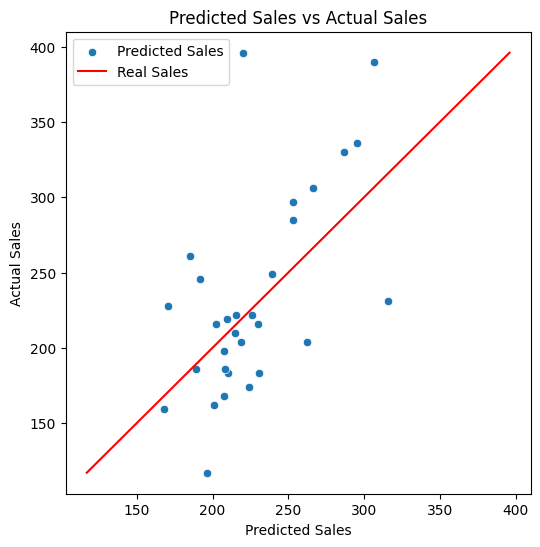

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred, y=y_test, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test, y=y_test, color="red", ax=ax, label="Real Sales")

# Save to MLFlow last run
fig_path = 'predictions_vs_ground_truth.png'
plt.savefig(fig_path)
mlflow.log_artifact(fig_path)

Mostramos la diferencia entre las ventas reales y las predicciones a lo largo del tiempo

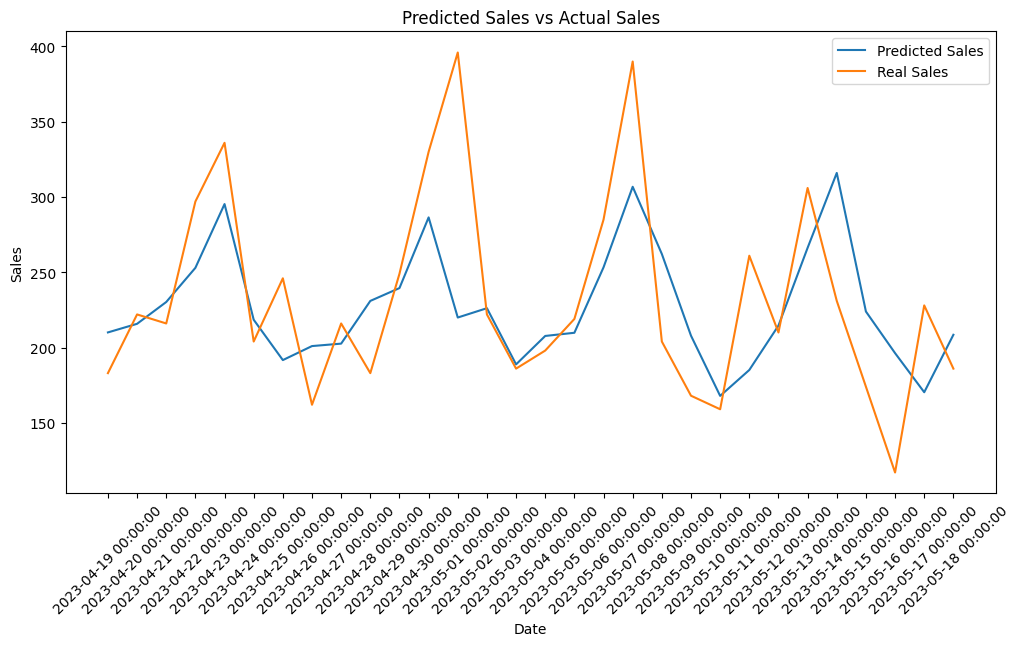

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test["fecha_venta"], rotation=45)

dates = df_test["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test, label="Real Sales")

# Save to MLFlow last run
fig_path = 'predictions_vs_ground_truth_timeline.png'
plt.savefig(fig_path)
mlflow.log_artifact(fig_path)

## 6. Productivización del modelo

👇 Utiliza tus conocimientos de MLOps para desplegar un modelo registrado en MLFlow. Si todo ha ido correctamente deberias ver unos logs similares a estos:

```bash
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started parent process [15]
INFO:     Started server process [20]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
```

## 7. Haz peticiones al modelo

Una vez has desplegado el modelo, puedes hacer peticiones al mismo. Aplica los conocimientos de comunicación entre servicios que hemos visto en clase para hacer una petición al modelo. Enviale el conjunto de test y obtendrás las predicciones del modelo.

- ⚠️ Importante: el campo `fecha_venta` debes convertirlo a `string` previamente para que pueda ser enviado al modelo.
- ⚠️ Importante: guarda las predicciones en una variable `predictions` para que puedas utilizarlas posteriormente.

In [ ]:
# 👇 add your code here



## 8. Sube tus resultados a la base de datos

Sube las predicciones devueltas por el modelo desplegado a la base de datos. De esta forma podras utilizarlos en Tableau, PowerBI, etc. Primero creamos el dataframe que subiremos a la base de datos. Este dataframe contendrá las siguientes columnas:

| **Columna**      | **Descripción**                                  |
|------------------|--------------------------------------------------|
| `fecha`          | Fecha de la predicción                           |
| `cantidad`       | Ventas predichas por el modelo                   |
| `articulo`       | ID del producto                                  |
| `familia`        | Familia del producto                             |


In [ ]:
dates = df_test["fecha_venta"].tolist()
predictions = y_pred

# Create a dataframe with the data to store
df_article_prediction = pd.DataFrame({
    "fecha": dates,
    "cantidad": predictions,
    "articulo": [PRODUCT_ID] * len(predictions),  # repeat the article for each date
    "familia": [product_family] * len(predictions),  # repeat the family for each date
})

df_article_prediction.head(5)

,fecha,cantidad,articulo,familia
0,2023-04-19,210.054475,3960,BOLLERIA
1,2023-04-20,215.770949,3960,BOLLERIA
2,2023-04-21,230.256587,3960,BOLLERIA
3,2023-04-22,252.956264,3960,BOLLERIA
4,2023-04-23,295.314118,3960,BOLLERIA


Subimos los resultados.

In [ ]:
# Database credentials
DATABASE = "sandbox"
NAME = "Mate"  # ‼️ Cambia esta variable por tu nombre. 

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(DB_USERNAME, DB_PASSWORD, database=DATABASE)
db.insert_dataframe(df_article_prediction, table_name)